In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import os

# Data - Sine Regression Task

In [2]:
from functools import partial


def uniform(shape, min_value, max_value):
    return torch.rand(*shape) * (max_value - min_value) + min_value


class MetaLoader:
    def __init__(self, num_tasks, samples_per_task):
        self.num_tasks = num_tasks
        self.samples_per_task = samples_per_task

    def __iter__(self):
        for ep in range(self.num_tasks):
            A = 0.1 + torch.rand(1) * (5.0 - 0.1)
            p = torch.rand(1) * np.pi
            
            x_supp = -5.0 + torch.rand(self.samples_per_task) * 10.0
            y_supp = A * torch.sin(x_supp - p)

            x_query = -5.0 + torch.rand(self.samples_per_task) * 10.0
            y_query = A * torch.sin(x_query - p)

            yield (x_supp.unsqueeze(1), y_supp.unsqueeze(1)), (x_query.unsqueeze(1), y_query.unsqueeze(1))
    
    def __len__(self):
        return self.num_tasks

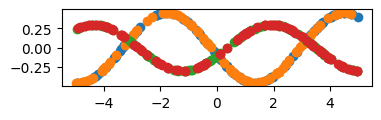

In [3]:
plt.figure(figsize=(4, 1))
for (x, y), (w, z) in MetaLoader(num_tasks=2, samples_per_task=100):
    plt.scatter(x.tolist(), y.tolist())
    plt.scatter(w.tolist(), z.tolist())

In [7]:
from torch.func import vmap, grad, functional_call
import torch.nn.functional as F
from torch import optim
import torch


class MAML():
    def __init__(self, model, meta_lr, inner_lr, inner_step, ts_inner_step, iterations, path):
        self.path = path # model checkpoint (for saving or load)

        self.model = model
        self.meta_lr = meta_lr   # beta learning rate in outer loop
        self.inner_lr = inner_lr # alfa learning rate in inner loop
        self.tr_inner_steps = inner_step # optimization step in inner loop during training
        self.ts_inner_steps = ts_inner_step # inner optimization steps during evaluation
        self.iterations = iterations  # epochs
        self.meta_optimizer = optim.Adam(self.model.parameters(), lr=self.meta_lr)
       
        # Store performance history
        self.best_loss = 100000  # trackng best loss for model checkpointing
        self.tr_history = {"tr_loss" : [], "tr_inner_loss": []}
        self.vl_history = {"vl_loss" : [], "vl_inner_loss": []}
    
    def _inner_loss(self, params, buffers, x, y):
        """functional call to compute loss on the support set"""
        y_out = functional_call(self.model, (params, buffers), x)
        return F.mse_loss(y_out, y)

    def _inner_loop(self, x_support, y_support, x_query, y_query):
        """Single task inner loop training."""
        # needed for functional call
        params = dict(self.model.named_parameters())
        buffers = dict(self.model.named_buffers())

        for _ in range(self.tr_inner_steps):  # inner loop optimization
            grads = grad(self._inner_loss)(params, buffers, x_support, y_support)
            # inner SGD step: params = params - alpha * grad(inner_loss, params)
            params = {k: params[k] - g * self.inner_lr for k, g, in grads.items()}

        # final losses on support and query set
        supp_loss = self._inner_loss(params, buffers, x_support, y_support)
        query_loss = self._inner_loss(params, buffers, x_query, y_query)
        return supp_loss, query_loss

    def train_episode(self, meta_loader):
        """Each episode we sample tasks from the meta-loader and optimize the initialization
        by minimizing the expected query loss w.r.t. the model initialization (outer loop). 
        The loss that we are minimizing is the avg validation loss over the tasks, computed 
        on the model obtained by finetuning the initialization for k steps (inner loop).
        """
        self.model.train()
        self.meta_optimizer.zero_grad()  # reset meta-gradients
        num_tasks = len(meta_loader)
        all_supp_loss, all_query_loss = 0, 0

        # we sample training tasks from the meta-loader.
        # each task provides support (train) and query (eval) samples
        # if you want, you can parallelize this loop with a vmap!
        for (x_support, y_support), (x_query, y_query) in meta_loader:           
            # inner loop for each task on support loss
            res = self._inner_loop(x_support, y_support, x_query, y_query)
            all_supp_loss += res[0]  # accumulate supp loss across all tasks
            all_query_loss += res[1]  # accumulate query loss across all tasks   

        # outer loop on query loss
        all_query_loss.sum().backward()  # meta-gradient of the meta losses (avg query loss for tasks in the episode)
        self.meta_optimizer.step()

        # track total loss and accuracy
        all_query_loss = (all_query_loss.detach().sum() / num_tasks).item()
        all_supp_loss = (all_supp_loss.detach().sum() / num_tasks).item()
        return all_supp_loss, all_query_loss

    def evaluation(self, meta_loader):
        """Evaluate the initialization on meta-loder tasks."""
        self.model.eval()
        supp_losses, query_losses = [], []

        for (x_support, y_support), (x_query, y_query) in meta_loader:
            new_params = dict(self.model.named_parameters())
            buffers = dict(self.model.named_buffers())

            # inner loop optimization with functional API
            # NOTE: we are training the init even for the evaluation!
            for _ in range(self.ts_inner_steps):  
                # forward pass with functional API
                supp_logits = functional_call(self.model, (new_params, buffers), x_support)
                # loss on support set
                supp_loss = F.mse_loss(supp_logits, y_support)
                # gradients of the support loss
                grads = torch.autograd.grad(supp_loss, new_params.values())
                # update the params with an SGD step
                new_params = {k: new_params[k] - g * self.inner_lr for k, g, in zip(new_params, grads)}

            # add support and query loss to history
            supp_losses.append(supp_loss.detach())
            qry_logits = functional_call(self.model, (new_params, buffers), x_query).detach()
            qry_loss = F.mse_loss(qry_logits, y_query, reduction='none')
            query_losses.append(qry_loss.detach())

        # get mean inner/meta performance over metabatches
        supp_losses = torch.mean(torch.stack(supp_losses)).item()
        query_losses = torch.cat(query_losses).mean().item()
        return supp_losses, query_losses

    def fit_and_evaluate(self, train_loader, eval_loader):
        """The code here is long but it's mostly printing/plotting, and tracking accuracies."""
        for iteration in range(self.iterations):
            tr_inner_loss, tr_loss = self.train_episode(train_loader)
            vl_inner_loss, vl_loss = self.evaluation(eval_loader)

            # add performance to history
            self.tr_history["tr_loss"].append(tr_loss)
            self.vl_history["vl_loss"].append(vl_loss)
            self.tr_history["tr_inner_loss"].append(tr_inner_loss)
            self.vl_history["vl_inner_loss"].append(vl_inner_loss)

            # pretty print
            if iteration % (self.iterations // 10) == 0 or iteration == self.iterations - 1:
                print(
                    f'[Epoch {iteration}] | ',
                    f'[TR] Meta Loss: {tr_loss:.2f} -',
                    f'Inner Loss: {tr_inner_loss:.2f} - |',
                    f'[VL] Meta Loss: {vl_loss:.2f} -  ',
                    f'Inner Loss: {vl_inner_loss:.2f} - |')

                self.model.eval()
                (x_support, y_support), _ = next(iter(eval_loader))
                new_params = dict(self.model.named_parameters())
                buffers = dict(self.model.named_buffers())
                # inner loop optimization
                for _ in range(self.ts_inner_steps):  
                    supp_logits = functional_call(self.model, (new_params, buffers), x_support)
                    supp_loss = F.mse_loss(supp_logits, y_support)
                    grads = torch.autograd.grad(supp_loss, new_params.values())
                    new_params = {k: new_params[k] - g * self.inner_lr for k, g, in zip(new_params, grads)}

                y_out = functional_call(self.model, (new_params, buffers), x_support)
                plt.figure(figsize=(4, 1))
                plt.scatter(x_support.tolist(), y_support.tolist(), label="true")
                plt.scatter(x_support.tolist(), y_out.tolist(), label="pred")
                plt.legend()

            # model checkpointing
            if vl_loss <= self.best_loss:  
                self.best_loss = vl_loss
                torch.save({
                    'epoch': iteration,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.meta_optimizer.state_dict(),
                    'loss': vl_loss,
                }, self.path)

        return self.tr_history, self.vl_history


# Run Experiment

In [6]:
from types import SimpleNamespace
data_root = './logs'
exp_root = './logs'
os.makedirs(exp_root, exist_ok=True)

model = torch.nn.Sequential(
    torch.nn.Linear(1, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 1)
).to('cpu')

maml = MAML(
    model=model,
    meta_lr=1e-3, 
    inner_lr=0.01, 
    inner_step=10, 
    ts_inner_step=10, 
    iterations=400, 
    path=data_root + "/model.pth"
)

train_loader = MetaLoader(num_tasks=10, samples_per_task=25)
test_loader = MetaLoader(num_tasks=10, samples_per_task=25)
tr_history, vl_history = maml.fit_and_evaluate(train_loader, test_loader)

KeyboardInterrupt: 

# Computational Graph

It's big and messy, but you can see that there is the whole computational graph in `all_query_loss`. Going from the leaf () towards the roots:
- We have two MSELossBackward: these are the losses computed on the finetuned model on the query sets
- The SGD updates for each task (SubBackward0): We have two because each task trained a different model
- The MSELossBackwardBackward: these are the inner loss computed on the support set for each task

Try to experiment with it!
- if you change the the number of SGD steps in the inner loop (`inner_steps`) you see that the computational graph grows deeper
    - each SGD step adds operations to the computational graph
- if you add more tasks (`num_tasks` in the `MetaLoader`) the graph grows "wider": each task trains a separate model, starting from the same init (the blue rectangles are the model's initialization parameters)

In [5]:
from torchviz import make_dot

model = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
    # torch.nn.ReLU(),
    # torch.nn.Linear(40, 1)
)

maml = MAML(
    model=model,
    meta_lr=1e-3, 
    inner_lr=0.01, 
    inner_step=2, 
    ts_inner_step=1, 
    iterations=400, 
    path=data_root + "/model.pth"
)

train_loader = MetaLoader(num_tasks=1, samples_per_task=3)
maml.model.train()
num_tasks = len(train_loader)
all_supp_loss, all_query_loss = 0, 0

for (x_support, y_support), (x_query, y_query) in train_loader:           
    # we are calling the private method of the class _inner_loop, 
    # which is something that you should avoid in general.
    # I'm doing it here only because it's the quickest way to create the torchviz plot

    # inner loop for each task on support loss
    res = maml._inner_loop(x_support, y_support, x_query, y_query)
    all_supp_loss += res[0]
    all_query_loss += res[1]   

make_dot(all_query_loss.sum(), params=dict(maml.model.named_parameters()))

NameError: name 'data_root' is not defined

# Exercises

if you studied the implementation above, understanding, and now you feel adventurous and want to test your knowledge, you can try to:
- implement first order MAML by truncating the gradient. You can use `torchviz` to debug your code. Plot the computational graph and check that the gradient is truncated.
- add momentum to the optimization step
- you can implement some of the MAML improvements in Antoniou, Antreas, Harrison Edwards, and Amos Storkey. "How to train your MAML." arXiv preprint arXiv:1810.09502 (2018).
    - some are quick and easy to implement, others may require more work
 
Keep in mind that these exercises are much more difficult than the previous notebooks.